In [ ]:
import torch

if torch.cuda.is_available():
    print(" GPU is available!")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print(" GPU not available, using CPU instead.")


✅ GPU is available!
Device name: Tesla T4


In [ ]:
!pip install PyMuPDF


  Using cached pymupdf-1.26.3-cp39-abi3-manylinux_2_28_x86_64.whl.metadata (3.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 54.4 MB/s eta 0:00:00


In [ ]:
# STEP 1: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import zipfile
import fitz  # For PDFs
import re
import json
from glob import glob
from collections import Counter

# STEP 2: Set root folders
base_dir = "/content/drive/MyDrive/Reports & Images"
infarcts_dir = os.path.join(base_dir, "Infarcts", "Infarcts")
normal_dir = os.path.join(base_dir, "Normal Patients")

# STEP 3: Unzip any .zip folders once
def unzip_all(root_dir):
    unzip_count = 0

    for folder, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".zip"):
                zip_path = os.path.join(folder, file)

                # Skip if any unzipped folder already exists
                unzipped_exists = any(
                    os.path.isdir(os.path.join(folder, f)) and not f.endswith(".zip")
                    for f in os.listdir(folder)
                )
                if unzipped_exists:
                    continue

                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(folder)
                        unzip_count += 1
                except Exception:
                    pass  # skip errors silently

    return unzip_count
unzipped = unzip_all(base_dir)
print(f"Total folders unzipped: {unzipped}")

import re

def extract_diagnostic_sections_only(text):
    # Normalize section headers
    text = re.sub(r'(?i)\b(FINDINGS|OBSERVATIONS|REPORT FINDINGS|REPORT RESULT)\b\s*[:\-\.]?', 'Findings:', text)
    text = re.sub(r'(?i)\b(CONCLUSION|IMPRESSION|CONC)\b\s*[:\-\.]?', 'Conclusion:', text)

    findings = ""
    conclusion = ""

    # Match the Findings section
    findings_match = re.search(r'Findings:\s*((?:.|\n)*?)(?=\n\s*Conclusion:|\Z)', text, re.IGNORECASE)
    if findings_match:
        findings = findings_match.group(1).strip()

        # After findings, match the Conclusion section if it exists
        post_findings_text = text[findings_match.end():]
        conclusion_match = re.search(r'Conclusion:\s*((?:.|\n)*?)(?=\n\s*\S+:|\Z)', post_findings_text, re.IGNORECASE)
        if conclusion_match:
            conclusion = conclusion_match.group(1).strip()

            # Remove unwanted footer lines like "Electronically signed by"
            footer_pattern = r'(Electronically Signed by:|Electronically\b|CONSULTANT RADIOLOGIST|AfyaRad).*'
            footer_start = re.search(footer_pattern, conclusion, re.IGNORECASE)
            if footer_start:
                conclusion = conclusion[:footer_start.start()].strip()
    else:
        # If no Findings, fallback: take entire text as findings
        findings = text.strip()

    return f"Findings:\n{findings}\n\nConclusion:\n{conclusion}".strip()


# STEP 5: File reader (PDF and TXT only)
def extract_text_from_report(report_path):
    ext = os.path.splitext(report_path)[1].lower()
    try:
        if ext == ".pdf":
            doc = fitz.open(report_path)
            return "\n".join([page.get_text() for page in doc])
        elif ext == ".txt":
            with open(report_path, 'r', encoding='utf-8', errors='ignore') as f:
                return f.read()
    except Exception as e:
        print(f" Error reading report {report_path}: {e}")
    return ""

# STEP 6: Utility
def is_image_file(filename):
    return filename.lower().endswith(('.dcm', '.bmp', '.png', '.jpg', '.jpeg'))

# STEP 7: Process folders recursively
def process_category(category_path, category_label, patient_start_index):
    dataset = []
    counter = patient_start_index
    for patient_folder in sorted(os.listdir(category_path)):
        patient_path = os.path.join(category_path, patient_folder)
        if not os.path.isdir(patient_path):
            continue

        # Find all images
        image_files = []
        for root, _, files in os.walk(patient_path):
            for f in files:
                if is_image_file(f):
                    image_files.append(os.path.join(root, f))

        # Locate report (PDF or TXT only)
        report_path = None
        for ext in ['pdf', 'txt']:
            found = glob(f"{patient_path}/**/*.{ext}", recursive=True)
            if found:
                report_path = found[0]
                break

        if not report_path or not image_files:
            continue  # skip incomplete

        raw_text = extract_text_from_report(report_path)
        cleaned_text = extract_diagnostic_sections_only(raw_text)

        dataset.append({
            "patient_id": f"ID{counter:04d}",
            "category": category_label,
            "image_paths": image_files,
            "report_text": cleaned_text
        })
        counter += 1

    return dataset, counter

# STEP 8: Process infarct categories
all_data = []
index = 0
infarct_categories = ["Acute", "Chronic", "Combination or Unclear", "Lacunar"]

for cat in infarct_categories:
    path = os.path.join(infarcts_dir, cat)
    cat_data, index = process_category(path, category_label=cat.lower(), patient_start_index=index)
    all_data.extend(cat_data)

# STEP 9: Process Normal category
normal_data, _ = process_category(normal_dir, category_label="normal", patient_start_index=index)
all_data.extend(normal_data)

print(f" Total patients processed: {len(all_data)}")

# STEP 10: Save cleaned dataset
output_file = "ct_reports_dataset_cleaned10.json"
with open(output_file, "w") as f:
    json.dump(all_data, f, indent=2)

# STEP 11: Download (optional)
from google.colab import files
files.download(output_file)




✅ Total folders unzipped: 0
✅ Total patients processed: 579


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# STEP 12: Summary Stats
category_counts = Counter(entry["category"] for entry in all_data)
normal_count = category_counts.get("normal", 0)
infarct_count = sum(count for cat, count in category_counts.items() if cat != "normal")

print("\n Category Breakdown:")
print(f" Stroke Patients (Infarcts): {infarct_count}")
print(f" Normal Patients          : {normal_count}")
print(f" Total Patients           : {len(all_data)}")

for cat, count in category_counts.items():
    print(f"  • {cat.title():<25}: {count}")

# STEP 13: Preview few entries
print("\n Sample Entries:")
for entry in all_data[:3]:
    print(f" Patient ID: {entry['patient_id']}")
    print(f"   Category : {entry['category']}")
    print(f"   # Images : {len(entry['image_paths'])}")
    print(f"   Report   :\n{entry['report_text'][:300]}...\n{'-'*60}")


📊 Category Breakdown:
🧠 Stroke Patients (Infarcts): 229
🙂 Normal Patients          : 350
🧾 Total Patients           : 579
  • Acute                    : 108
  • Chronic                  : 15
  • Combination Or Unclear   : 70
  • Lacunar                  : 36
  • Normal                   : 350

🔍 Sample Entries:
🔹 Patient ID: ID0000
   Category : acute
   # Images : 34
   Report   :
Findings:
;
There is a right parietal intra-parenchymal well-defined irregular hyperdensity measuring 3.8cm X 2.9cm (APXML) adjacent
to the the right thalamus. Minimal mass effect is noted on the left lateral ventricle with no midline shift.
Hyperdense material is noted in the right lateral ventricl...
------------------------------------------------------------
🔹 Patient ID: ID0001
   Category : acute
   # Images : 31
   Report   :
Findings:
Noted global atrophy which is probably age related.
There is a region of hypoattenuation(22HU compared to 36HU of normal brain tissue) in the left temporal lobe measur

In [ ]:
# 🔍 Analyze skipped patients per category and show folder paths
from collections import defaultdict

# We'll reuse the base folders and scan them all again just to log the skipped folders
def find_skipped_patient_folders(category_paths, all_data):
    processed_paths = set(os.path.dirname(p["image_paths"][0]) for p in all_data if p["image_paths"])
    skipped_by_category = defaultdict(list)

    for category_name, path in category_paths.items():
        for patient_folder in sorted(os.listdir(path)):
            patient_path = os.path.join(path, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            # Check if any subfolder matches a processed patient path
            found_image = any(
                os.path.isdir(os.path.join(patient_path, f)) and not f.endswith(".zip")
                for f in os.listdir(patient_path)
            )
            found_pdf_or_txt = any(
                glob(os.path.join(patient_path, "**", "*.[pt][xd][ft]"), recursive=True)
            )

            # Skip if we already processed this path
            if any(patient_path in p for p in processed_paths):
                continue

            # If either report or image is missing
            if not (found_image and found_pdf_or_txt):
                reason = []
                if not found_pdf_or_txt:
                    reason.append("missing report")
                if not found_image:
                    reason.append("missing image")
                skipped_by_category[category_name].append((patient_path, ", ".join(reason)))

    return skipped_by_category

# Define the folder paths for analysis
category_paths = {
    "acute": os.path.join(infarcts_dir, "Acute"),
    "chronic": os.path.join(infarcts_dir, "Chronic"),
    "combination or unclear": os.path.join(infarcts_dir, "Combination or Unclear"),
    "lacunar": os.path.join(infarcts_dir, "Lacunar"),
    "normal": normal_dir
}

# Run skip analysis
skipped_folders = find_skipped_patient_folders(category_paths, all_data)

# Summary
print("\n Skipped Patients (Double Check):")
total_skipped = 0
for category, skipped_list in skipped_folders.items():
    print(f"  • {category.title():<25}: {len(skipped_list)}")
    total_skipped += len(skipped_list)
print(f"\n Total Skipped Patients           : {total_skipped}")

# Show paths
print("\n Skipped Patient Folder Paths:")
for category, skipped_list in skipped_folders.items():
    for path, reason in skipped_list:
        print(f"[{category}] {reason:<20} --> {path}")



🚫 Skipped Patients (Double Check):
  • Acute                    : 39
  • Chronic                  : 6
  • Combination Or Unclear   : 13
  • Lacunar                  : 7
  • Normal                   : 1

❌ Total Skipped Patients           : 66

📂 Skipped Patient Folder Paths:
[acute] missing report       --> /content/drive/MyDrive/Reports & Images/Infarcts/Infarcts/Acute/Patient 100
[acute] missing report       --> /content/drive/MyDrive/Reports & Images/Infarcts/Infarcts/Acute/Patient 105
[acute] missing report       --> /content/drive/MyDrive/Reports & Images/Infarcts/Infarcts/Acute/Patient 106
[acute] missing report       --> /content/drive/MyDrive/Reports & Images/Infarcts/Infarcts/Acute/Patient 112
[acute] missing report       --> /content/drive/MyDrive/Reports & Images/Infarcts/Infarcts/Acute/Patient 114
[acute] missing report       --> /content/drive/MyDrive/Reports & Images/Infarcts/Infarcts/Acute/Patient 115
[acute] missing report       --> /content/drive/MyDrive/Reports & Ima

In [ ]:
!cp -r "/content/drive/MyDrive/ct_reports_dataset_corrected10.json" /content/

In [ ]:
!cp -r /content/drive/MyDrive/Reports\ \&\ Images /content/data


In [ ]:
!zip -r /content/reports_images_dataset.zip "/content/drive/MyDrive/Reports & Images"


Scanning files .........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
import json

with open("ct_reports_dataset_corrected10.json", "r") as f:
    dataset = json.load(f)

for entry in dataset:
    updated_paths = []
    for path in entry["image_paths"]:
        if path.startswith("/content/drive/MyDrive/Reports & Images"):
            new_path = path.replace("/content/drive/MyDrive/Reports & Images", "/content/data")
            updated_paths.append(new_path)
        else:
            updated_paths.append(path)
    entry["image_paths"] = updated_paths

# Save new JSON
with open("ct_reports_dataset_corrected10.json", "w") as f:
    json.dump(dataset, f, indent=2)

print("Paths updated and new JSON saved.")


✅ Paths updated and new JSON saved.


In [ ]:
!pip install pylibjpeg pylibjpeg-libjpeg gdcm pydicom
!pip install python-gdcm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.8 MB/s eta 0:00:00


In [ ]:
!ls -lh ct_reports_dataset_corrected10.json


-rw------- 1 root root 18M Jul 18 06:02 ct_reports_dataset_corrected10.json


In [ ]:
!tail -n 10 ct_reports_dataset_corrected10.json


      "/content/data/Normal Patients/Patient 99_52/Patient 99_52 NC/TUSINGWIRE_HOPE.CT.Brain_[factory].501.1.2024.04.17.10.05.41.987.13429655.dcm",
      "/content/data/Normal Patients/Patient 99_52/Patient 99_52 NC/TUSINGWIRE_HOPE.CT.Brain_[factory].3.35.2024.04.17.10.05.41.987.13429644.dcm",
      "/content/data/Normal Patients/Patient 99_52/Patient 99_52 NC/TUSINGWIRE_HOPE.CT.Brain_[factory].3.32.2024.04.17.10.05.41.987.13429611.dcm",
      "/content/data/Normal Patients/Patient 99_52/Patient 99_52 NC/TUSINGWIRE_HOPE.CT.Brain_[factory].3.31.2024.04.17.10.05.41.987.13429600.dcm",
      "/content/data/Normal Patients/Patient 99_52/Patient 99_52 NC/TUSINGWIRE_HOPE.CT.Brain_[factory].3.25.2024.04.17.10.05.41.987.13429534.dcm",
      "/content/data/Normal Patients/Patient 99_52/Patient 99_52 NC/TUSINGWIRE_HOPE.CT.Brain_[factory].3.26.2024.04.17.10.05.41.987.13429545.dcm"
    ],
    "report_text": "Findings:\nThere is no intra-axial lesion in the cerebral hemispheres. The gray-white diffe

In [ ]:
import json

# Load your JSON file
with open("ct_reports_dataset_corrected10.json", "r") as f:
    data = json.load(f)

# Print total entries
print(f"Total entries: {len(data)}\n")

# Display the first 10 reports with first image path
for i in range(min(20, len(data))):
    sample = data[i]
    print(f"📄 Sample {i + 1}")
    print(f"Patient ID       : {sample['patient_id']}")
    print(f"Number of images : {len(sample['image_paths'])}")

    # Show first image path if available
    if sample['image_paths']:
        print(f"First Image Path : {sample['image_paths'][0]}")
    else:
        print("First Image Path : N/A")

    print("\nFull Report:")
    print(sample['report_text'].strip())
    print("-" * 100)


Total entries: 579

📄 Sample 1
Patient ID       : ID0000
Number of images : 34
First Image Path : /content/data/Infarcts/Infarcts/Acute/Bakazi Grace/BAKAZI GRACE/BAKAZI- GRACE- 6-25-1966- CT from 6-25-2024 S0 I0.BMP

Full Report:
Findings:
;
There is a right parietal intra-parenchymal well-defined irregular hyperdensity measuring 3.8cm X 2.9cm (APXML) adjacent
to the the right thalamus. Minimal mass effect is noted on the left lateral ventricle with no midline shift.
Hyperdense material is noted in the right lateral ventricle.
The rest of the cerebral hemispheric parenchyma is normal with normal grey-white matter differentiation.
The caudate and lentiform nuclei and the thalami are normal. 
The corpus callosum, the anterior and posterior commissure are normal. 
The midbrain, pons and medulla are normal.
The superior, middle and inferior cerebellar peduncles are normal.
The cerebellar vermis and the cerebellar hemispheric parenchyma reveal no abnormality.
The rest of the ventricles and 

In [ ]:
pip install pydicom

In [ ]:
empty_count = 0
short_count = 0

for entry in data:
    report = entry.get("report_text", "").strip()
    if not report or report.lower() in ["findings:", "findings: conclusion:", "conclusion:"]:
        empty_count += 1
    elif len(report.split()) < 50:
        short_count += 1

print(f"Empty reports: {empty_count}")
print(f"Very short reports (<50 words): {short_count}")


Empty reports: 0
Very short reports (<50 words): 0


In [ ]:
import os

# Set a word threshold for short reports
SHORT_REPORT_WORD_THRESHOLD = 50

short_entries = []

# Loop through the dataset to find short reports and show their file paths
for entry in data:
    report = entry.get('report_text', '').strip()
    word_count = len(report.split())

    if word_count < SHORT_REPORT_WORD_THRESHOLD:
        short_entries.append(entry)
        print(" Patient ID:", entry.get('patient_id', 'Unknown'))
        print(" Report Words:", word_count)
        print(" Report Text Preview:", repr(report[:150]))

        if entry.get('image_paths'):
            sample_path = entry['image_paths'][0]
            print(" Sample Image Path:", sample_path)
            print(" Folder to Check:", os.path.dirname(sample_path))
        else:
            print(" No image paths available.")

        print("-" * 80)

print(f"\n Total short reports (<{SHORT_REPORT_WORD_THRESHOLD} words): {len(short_entries)}")



 Total short reports (<50 words): 0


In [ ]:
import json

# Load the current cleaned dataset
with open("ct_reports_dataset_cleaned10.json", "r") as f:
    data = json.load(f)

# Manually update specific entries
for entry in data:
    if entry["patient_id"] == "ID0010":
        entry["report_text"] = """Findings:
There is an intraparenchymal hyperdensity involving the left insular cortex surrounded by a ring of edema. It measures 25.9 x
12.23 mm. There is no mass effect on the adjacent structures.Its density is 77 HU.
The grey-white matter differentiation is normal.
The ventricles and sulci are normal. The extra axial spaces are normal. No collections are seen.
The ambient and quadrigeminal cisterns are not effaced.
The orbital structures are normal.
There isopacification of the left maxillary sinus with obliteration of the ipsilateral osteomeatal complexes. The rest of the
paranasal sinuses are well aerated.
The skull bones are normal.

Conclusion:
acute hemorrhagic stroke in the territory of the left middle cerebral artery.
Left maxillary sinusitis."""

    elif entry["patient_id"] == "ID0016":
        entry["report_text"] = """Findings:
There is a feeding tube in situ
There is a geographical hypo density involving the left temporal-parietal region. It measures 102 x 32 mm. Its density is
23HU compared to the contralateral parenchyma 30HU. It does not exert mass effect on the surrounding parenchyma. The
adjacent sulci are effaced and the gray-white matter definition is lost.
There ventricles are normal but sulci, are widened (10mm).
The ambient and quadrigeminal cisterns are not widened.
The orbits and skull bones are normal.
The paranasal sinuses and mastoid air cells are well aerated.

Conclusion:
acute ischemic infarct in the territory of left middle cerebral artery.
Mild cerebral atrophy is compatible with age."""

    elif entry["patient_id"] == "ID0028":
        entry["report_text"] = """Findings:
The main finding here is the non enhancing hypodense lesion in the right basal ganglia, lentiform and quadrigerminal
nuclei , extending into the parietal lobe.
There is slight compression of the ipsilateral lateral ventricle, but minimal mass effect on the midline structures.
A positive right MCA sign is demonstrated.
The rest of the brain shows non remarkable findings and no other focal lesions seen.
Conclusion:
Acute right parietal lobe cerebral infarction. To be correlated clinically."""

    elif entry["patient_id"] == "ID0107":
        entry["report_text"] = """Findings:
The main finding here is the extensive hypodense lesion in the left basal ganglia, parietal lobe, extending into the temporal
lobe.
There is effacement of the sulci and compression of the ipsilateral lateral ventricle.
A positive left MCA sign is demonstrated.
The rest of the brain shows non remarkable findings and no other focal lesions seen.
Conclusion:
Acute left parietal lobe cerebral infarction."""

    elif entry["patient_id"] == "ID0108":
        entry["report_text"] = """Findings:
The main finding here are the extensive hypodense lesion in the bifrontal lobes,
There is effacement of the sulci and dilatation of the frontal Horna of the lateral ventricles.
The rest of the brain shows non remarkable findings and no other focal lesions seen.
Conclusion:
Extensive bifrontal lobes chronic ischeamic cerebral infarctions, with gloisis, to be corelated with the clinical
feature. A contrasted study is advised."""

    elif entry["patient_id"] == "ID0124":
        entry["report_text"] = """Findings:
There is a hyper density involving the left basal ganglia. It measures 36 x 30 mm. Its density is 73.4HU compared to the
contralateral perenchyma 39.4HU. It exerts mass effect on the surrounding tissues causing compression of the left lateral
ventricle. It is also surrounded by a ring of edema. The adjacent sulci are effaced and the gray-white matter definition is
lost.
The extra axial space, ambient and quadrigeminal cisterns are normal.
There is no shift of mid line structures.
The orbits and skull bones appear normal.
The mastoid air-cells are well aerated .
The paranasal sinuses, nasal turbinates and nasal septum are normal.
Conclusion:
Findings are in keeping with hemorrhagic stroke in the distribution of the left middle cerebral artery.
Mild cerebral edema."""

    elif entry["patient_id"] == "ID0166":
        entry["report_text"] = """Findings:
The main finding here are the extensive hypodense lesion in the parietal lobes , extending into the temperal lobe on the
left. The right is more hypodense
There is effacement of the sulci and compression of the ipsilateral lateral ventricle.
A similar but subtle hypodensity is noted in the left basal ganglia region, probably more acute.
The rest of the brain shows non remarkable findings and no other focal lesions seen.
Conclusion:
Extensive bilateral parietal lobes acut on chronic ischeamic cerebral infarctions, the left basal ganglia
appearing more acute and inline with the clinical feature."""

    elif entry["patient_id"] == "ID0373":
        entry["report_text"] = """Findings:
Normal attenuation of the cortex and white matter of both cerebral hemispheres.
- No focal lesions could be detected.
- No intra or extra-axial collections identified.
- Normal supra and infratentorial ventricular systems.
- No mass effect and no midline shift.
- Normal posterior fossa structures.
- Normal calvarium, no evidence of fracture.
- Otherwise, normal age-matched pneumatization of all paranasal sinus groups, namely the
maxillary, frontal, sphenoid sinuses as well as the ethmoid air cells.
- The paranasal sinuses have intact bony walls, mucosal linings.
- Normal CT features of the nasal vault showing central nasal septum and normal size and
configuration of the nasal turbinates.
- Normal CT features of the naso-pharyngeal structures, with patent air way.
Conclusion:
Normal findings. An MRI may show more."""

    elif entry["patient_id"] == "ID0389":
        entry["report_text"] = """Findings:
Normal attenuation of the cortex and white matter of both cerebral hemispheres.
- No focal lesions could be detected.
- No intra or extra-axial collections identified.
- Normal supra and infratentorial ventricular systems.
- No mass effect and no midline shift.
- Normal posterior fossa structures.
- Normal calvarium, no evidence of fracture.
- Left maxillary antral polyp, Otherwise, normal age-matched pneumatization of all paranasal
sinus groups, namely the right maxillary, frontal, sphenoid sinuses as well as the ethmoid air
cells.
- The paranasal sinuses have intact bony walls, mucosal linings.
- Normal CT features of the nasal vault showing central nasal septum and normal size and
configuration of the nasal turbinates.
- Normal CT features of the naso-pharyngeal structures, with patent air way.
Conclusion:
Nonremarkable brain findings, a follow-up scan is advised in 24 hours to rule out ischaemic
stroke. Left maxillary polypy ( incidental finding)"""

    elif entry["patient_id"] == "ID0535":
        entry["report_text"] = """Findings:
Normal attenuation of the cortex and white matter of both cerebral hemispheres.
- No focal lesions could be detected.
- No intra or extra-axial collections identified.
- Normal supra and infratentorial ventricular systems.
- No mass effect and no midline shift.
- Normal posterior fossa structures.
- Normal calvarium, no evidence of fracture.
- Otherwise, normal age-matched pneumatization of all paranasal sinus groups, namely the
maxillary, frontal, sphenoid sinuses as well as the ethmoid air cells.
- The paranasal sinuses have intact bony walls, mucosal linings.
- Normal CT features of the nasal vault showing central nasal septum and normal size and
configuration of the nasal turbinates.
- Normal CT features of the naso-pharyngeal structures, with patent air way.
Conclusion:
Non remarkable findings"""

# Save updated dataset to a new file
corrected_file = "ct_reports_dataset_corrected10.json"
with open(corrected_file, "w") as f:
    json.dump(data, f, indent=2)

print(" Manual edits completed and saved.")


✅ Manual edits completed and saved.


In [ ]:
from google.colab import files
files.download("ct_reports_dataset_corrected10.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🧪 Testing DICOM loading on: /content/data/Infarcts/Infarcts/Acute/Patient 101/Patient 101/MABABZI_MARY.CT.Brain_[factory].2.10.2024.01.23.11.55.24.557.75248694.dcm
 DICOM image processed.
Raw shape: (512, 512)  | Processed shape: (512, 512)


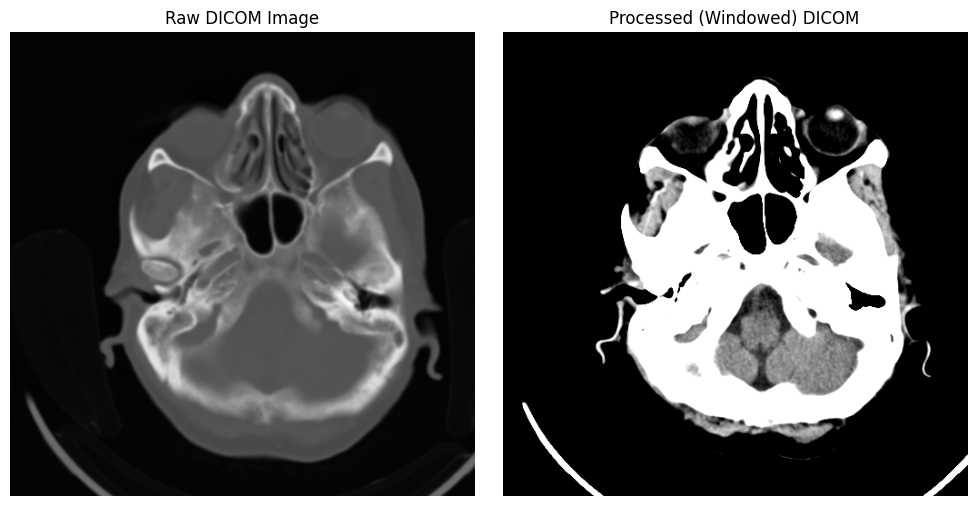

In [ ]:
import os
import json
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from pydicom.errors import InvalidDicomError

# ---------- Load Dataset ----------
json_path = "ct_reports_dataset_corrected10.json"
with open(json_path, "r") as f:
    full_data = json.load(f)

# ---------- DICOM Processor ----------
def process_dicom_image(path, window_center=40, window_width=80):
    try:
        dcm = pydicom.dcmread(path, force=True)
        image = dcm.pixel_array.astype(np.float32)
        intercept = float(getattr(dcm, "RescaleIntercept", 0))
        slope = float(getattr(dcm, "RescaleSlope", 1))
        hu_image = image * slope + intercept

        # Apply windowing
        img_min = window_center - window_width / 2
        img_max = window_center + window_width / 2
        windowed = np.clip(hu_image, img_min, img_max)
        windowed = (windowed - img_min) / (img_max - img_min) * 255.0
        return windowed.astype(np.uint8), dcm.pixel_array
    except (InvalidDicomError, AttributeError, Exception) as e:
        print(f" Error processing DICOM: {path} — {e}")
        return None, None

# ---------- Find and Display First Valid DICOM ----------
dicom_path = None
for entry in full_data:
    for path in entry["image_paths"]:
        if path.lower().endswith(".dcm"):
            dicom_path = path
            break
    if dicom_path:
        break

if dicom_path:
    print("🧪 Testing DICOM loading on:", dicom_path)
    processed_img, raw_img = process_dicom_image(dicom_path)

    if processed_img is not None and raw_img is not None:
        print(" DICOM image processed.")
        print("Raw shape:", raw_img.shape, " | Processed shape:", processed_img.shape)

        # Show raw and processed images
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Raw DICOM Image")
        plt.imshow(raw_img, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Processed (Windowed) DICOM")
        plt.imshow(processed_img, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(" Failed to process DICOM image.")
else:
    print(" No DICOM image found in dataset.")


In [ ]:
import json

# Load dataset
with open("ct_reports_dataset_corrected10.json", "r") as f:
    full_data = json.load(f)

# Count images
total_images = 0
normal_images = 0
infarct_images = 0

# Track max images per patient
max_images = 0
max_patient_id = None

for entry in full_data:
    num_images = len(entry["image_paths"])
    total_images += num_images

    # Update max if this patient has more images
    if num_images > max_images:
        max_images = num_images
        max_patient_id = entry.get("patient_id", "Unknown")  # Correct key

    for path in entry["image_paths"]:
        if "Normal Patients" in path:
            normal_images += 1
        elif "Infarcts" in path:
            infarct_images += 1

print("Image Counts ")
print(f"Total images: {total_images}")
print(f"Normal images: {normal_images}")
print(f"Infarct images: {infarct_images}")
print("\nPatient with most images")
print(f"Patient ID: {max_patient_id}")
print(f"Number of images: {max_images}")


Image Counts 
Total images: 144702
Normal images: 92401
Infarct images: 52301

Patient with most images
Patient ID: ID0298
Number of images: 2486


In [ ]:
def preprocess_image(path, size=(224, 224)):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".dcm":
        img, _ = process_dicom_image(path)
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)  # Force color read
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    if img is None:
        return None

    # If grayscale (single channel), convert to RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # If RGBA (4 channels), convert to RGB
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    img_resized = cv2.resize(img, size)
    img_normalized = img_resized / 255.0
    return img_normalized

In [ ]:
with open("ct_reports_dataset_corrected10.json", "r") as f:
    full_data = json.load(f)

In [ ]:
import random

# Separate entries
infarcts = [entry for entry in full_data if any("Infarcts" in path for path in entry["image_paths"])]
normal = [entry for entry in full_data if any("Normal Patients" in path for path in entry["image_paths"])]

# Print original counts
print("Original Counts:")
print(f"Normal patients:   {len(normal)}")
print(f"Infarct patients:  {len(infarcts)}")
print(f"Total before balancing and oversampling: {len(normal) + len(infarcts)}")

# Sample more infarcts and normals
extra_infarcts = random.choices(infarcts, k=int(len(infarcts) * 1.3))  # 100% more
extra_normal = random.choices(normal, k=int(len(normal) * 0.5))      # 50% more

# Combine to form balanced data
balanced_data = normal + infarcts + extra_infarcts + extra_normal
random.shuffle(balanced_data)

# Print new counts
print("\nAfter Oversampling :")
print(f"Normal patients:   {len(normal)} + {len(extra_normal)} (duplicated) = {len(normal) + len(extra_normal)}")
print(f"Infarct patients:  {len(infarcts)} + {len(extra_infarcts)} (duplicated) = {len(infarcts) + len(extra_infarcts)}")
print(f"Total after balancing and oversampling: {len(balanced_data)}")


Original Counts:
Normal patients:   350
Infarct patients:  229
Total before balancing and oversampling: 579

After Oversampling :
Normal patients:   350 + 175 (duplicated) = 525
Infarct patients:  229 + 297 (duplicated) = 526
Total after balancing and oversampling: 1051


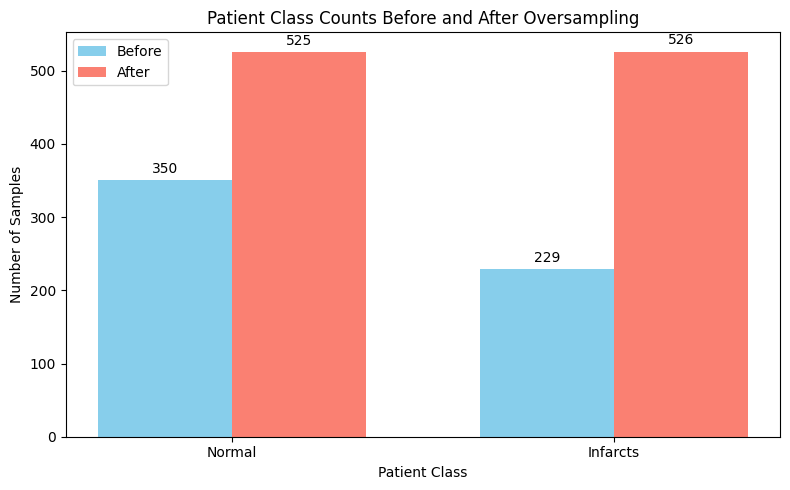

In [ ]:
import matplotlib.pyplot as plt

# Categories (Normal, Infarcts)
labels = ['Normal', 'Infarcts']

# Counts before oversampling
before_counts = [len(normal), len(infarcts)]

# Counts after oversampling
after_counts = [len(normal) + len(extra_normal), len(infarcts) + len(extra_infarcts)]

# X positions
x = range(len(labels))  # [0, 1]
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Bar plots: Before and After
bars_before = ax.bar([p - bar_width/2 for p in x], before_counts, bar_width, label='Before', color='skyblue')
bars_after = ax.bar([p + bar_width/2 for p in x], after_counts, bar_width, label='After', color='salmon')

# Labels and title
ax.set_xlabel('Patient Class')
ax.set_ylabel('Number of Samples')
ax.set_title('Patient Class Counts Before and After Oversampling')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bar values
for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Use the validated and limited dataset
train_entries, test_entries = train_test_split(balanced_data, test_size=0.2, random_state=42)


print(f"Training samples: {len(train_entries)}")
print(f"Testing samples: {len(test_entries)}")


✅ Training samples: 840
✅ Testing samples: 211


In [ ]:
!pip install transformers -q  # Make sure latest is installed

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

In [ ]:
processor = BlipProcessor.from_pretrained("khalednabawi11/blip-roco-model")
model = BlipForConditionalGeneration.from_pretrained("khalednabawi11/blip-roco-model")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class CTBLIPDataset(Dataset):
    def __init__(self, entries, size=(224, 224)):
        self.entries = []
        self.size = size

        for entry in entries:
            img_path = entry["image_paths"][len(entry["image_paths"]) // 2]
            img = preprocess_image(img_path, size=size)
            if img is not None:
                entry["_image"] = img
                self.entries.append(entry)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        img = entry["_image"]
        report = entry["report_text"]
        path = entry["image_paths"][len(entry["image_paths"]) // 2]

        img_tensor = torch.tensor(img).permute(2, 0, 1)
        return img_tensor, report, path


In [ ]:
import os
import zipfile

def safe_unzip_if_needed(data_dir):
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(".zip"):
                zip_path = os.path.join(root, file)
                parent_dir = os.path.dirname(zip_path)

                # Check if there is any unzipped folder (any directory except zip files) in parent_dir
                non_zip_entries = [f for f in os.listdir(parent_dir) if not f.lower().endswith(".zip")]
                unzipped_dirs = [f for f in non_zip_entries if os.path.isdir(os.path.join(parent_dir, f))]

                if unzipped_dirs:
                    # Unzipped folder exists, skip quietly
                    continue
                else:
                    try:
                        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                            zip_ref.extractall(parent_dir)
                        print(f"✅ Unzipped {zip_path} to {parent_dir}")
                    except Exception as e:
                        print(f"❌ Failed to unzip {zip_path}: {e}")

# Usage example
safe_unzip_if_needed("/content/data")


KeyboardInterrupt: 

In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_dataset = CTBLIPDataset(train_entries)
test_dataset = CTBLIPDataset(test_entries)

 Error processing DICOM: /content/data/Normal Patients/Patient 376_65/Patient 376_65 NC/NYABUTONO_VENER.CT.Brain_[factory].601.1.2024.08.20.11.17.24.215.75298710.dcm — The dataset has no 'Pixel Data', 'Float Pixel Data' or 'Double Float Pixel Data' element, no pixel data to decode
 Error processing DICOM: /content/data/Normal Patients/Patient 376_65/Patient 376_65 NC/NYABUTONO_VENER.CT.Brain_[factory].601.1.2024.08.20.11.17.24.215.75298710.dcm — The dataset has no 'Pixel Data', 'Float Pixel Data' or 'Double Float Pixel Data' element, no pixel data to decode
 Error processing DICOM: /content/data/Normal Patients/Patient 214_14/Patient 214_14 C&NC/NUWAGABA_LEROY.CT.Brain_[factory].601.2.2024.01.04.16.52.17.109.58537214.dcm — The dataset has no 'Pixel Data', 'Float Pixel Data' or 'Double Float Pixel Data' element, no pixel data to decode


In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1,pin_memory=True)

In [ ]:
!cp -r "/content/drive/MyDrive/best_blip_model3.zip" /content/

In [ ]:
import zipfile
import os

zip_path = "best_blip_model3.zip"  # Name of uploaded file
extract_path = "./best_blip_model3"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Model unzipped to:", extract_path)


 Model unzipped to: ./best_blip_model3


In [ ]:
import os

for root, _, files in os.walk("./best_blip_model3"):
    for file in files:
        print(file)


tokenizer_config.json
tokenizer.json
model.safetensors
preprocessor_config.json
config.json
vocab.txt
special_tokens_map.json
generation_config.json


In [ ]:
from transformers import BlipForConditionalGeneration, BlipProcessor
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correct directory
model_dir = "/content/best_blip_model3/best_blip_model3"

# Load model and processor
model = BlipForConditionalGeneration.from_pretrained(
    model_dir,
    use_safetensors=True
).to(device)

processor = BlipProcessor.from_pretrained(model_dir)

print(" Model and processor loaded successfully.")


 Model and processor loaded successfully.


In [ ]:
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup
from torch.cuda.amp import autocast, GradScaler

# Setup
accumulation_steps = 4
num_epochs = 30  # or your preferred number
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# AMP Scaler
scaler = GradScaler()

best_loss = float('inf')
global_step = 0

def train_one_epoch_blip(epoch):
    global best_loss, global_step
    model.train()
    total_loss = 0

    for step, (imgs, reports, paths) in enumerate(train_loader):

        pil_images = []

        for img_tensor in imgs:
            img_np = (img_tensor.permute(1, 2, 0).cpu().clamp(0, 1).numpy() * 255).astype("uint8")
            pil_img = Image.fromarray(img_np)
            pil_images.append(pil_img)

        # Tokenize
        inputs = processor(images=pil_images, text=reports, return_tensors="pt",
                           padding="max_length", truncation=True).to(device)

        with autocast():  # Mixed precision
            outputs = model(**inputs, labels=inputs.input_ids)
            loss = outputs.loss / accumulation_steps  # Gradient Accumulation

        scaler.scale(loss).backward()

        # Step only every accumulation_steps
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            global_step += 1

        total_loss += loss.item() * accumulation_steps  # Undo division for logging

    avg_loss = total_loss / len(train_loader)
    print(f" Epoch {epoch+1} - BLIP Training Loss: {avg_loss:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        save_path = "best_blip_model4"
        model.save_pretrained(save_path)
        processor.save_pretrained(save_path)
        print(f" New best model saved with loss {avg_loss:.4f} at '{save_path}'")


/tmp/ipython-input-49-1238731803.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
for epoch in range(num_epochs):
    train_one_epoch_blip(epoch)


/tmp/ipython-input-49-1238731803.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


 Epoch 1 - BLIP Training Loss: 0.0373
 New best model saved with loss 0.0373 at 'best_blip_model4'
 Epoch 2 - BLIP Training Loss: 0.0360
 New best model saved with loss 0.0360 at 'best_blip_model4'
 Epoch 3 - BLIP Training Loss: 0.0335
 New best model saved with loss 0.0335 at 'best_blip_model4'
 Epoch 4 - BLIP Training Loss: 0.0304
 New best model saved with loss 0.0304 at 'best_blip_model4'
 Epoch 5 - BLIP Training Loss: 0.0268
 New best model saved with loss 0.0268 at 'best_blip_model4'
 Epoch 6 - BLIP Training Loss: 0.0233
 New best model saved with loss 0.0233 at 'best_blip_model4'
 Epoch 7 - BLIP Training Loss: 0.0198
 New best model saved with loss 0.0198 at 'best_blip_model4'
 Epoch 8 - BLIP Training Loss: 0.0167
 New best model saved with loss 0.0167 at 'best_blip_model4'
 Epoch 9 - BLIP Training Loss: 0.0139
 New best model saved with loss 0.0139 at 'best_blip_model4'
 Epoch 10 - BLIP Training Loss: 0.0113
 New best model saved with loss 0.0113 at 'best_blip_model4'
 Epoch 11

In [ ]:

!zip -r best_blip_model4.zip best_blip_model4


  adding: best_blip_model4/ (stored 0%)
  adding: best_blip_model4/tokenizer_config.json (deflated 73%)
  adding: best_blip_model4/tokenizer.json (deflated 71%)
  adding: best_blip_model4/model.safetensors (deflated 8%)
  adding: best_blip_model4/preprocessor_config.json (deflated 52%)
  adding: best_blip_model4/config.json (deflated 67%)
  adding: best_blip_model4/vocab.txt (deflated 53%)
  adding: best_blip_model4/special_tokens_map.json (deflated 80%)
  adding: best_blip_model4/generation_config.json (deflated 29%)


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8d0b086c0cd285cf9ee6e62c68a61dedcaf7fad935bf5c192f00730883ceacf7
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
import torch
import evaluate
from transformers import BlipForConditionalGeneration, BlipProcessor

# === STEP 1: Load best saved model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "best_blip_model4"  # Updated path after renaming
model = BlipForConditionalGeneration.from_pretrained(best_model_path).to(device)
processor = BlipProcessor.from_pretrained(best_model_path)
model.eval()

# === STEP 2: Load evaluation metrics ===
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
# bertscore = evaluate.load("bertscore")

# === STEP 3: Create DataLoader for test set ===
test_loader = DataLoader(test_dataset, batch_size=1)

predictions = []
references = []

# === STEP 4: Inference loop ===
for imgs, reports, paths in tqdm(test_loader):
    img_tensor = imgs[0]

    # Convert tensor image to PIL image
    img_np = (img_tensor.permute(1, 2, 0).cpu().clamp(0, 1).numpy() * 255).astype("uint8")
    pil_img = Image.fromarray(img_np)

    inputs = processor(images=pil_img, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=inputs.pixel_values,
            max_new_tokens=256
        )

    pred_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    ref_text = reports[0]

    predictions.append(pred_text.strip())
    references.append(ref_text.strip())

# === STEP 5: Compute Scores ===
bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])
rouge_score = rouge.compute(predictions=predictions, references=references)

# === STEP 6: Print Results ===
print("\n Evaluation Results")
print("BLEU:", bleu_score)
print("ROUGE:", rouge_score)

#blue measures how similar a generated text is to a reference text
# 'rouge1':     Overlap of individual words (unigrams)
# 'rouge2':     Overlap of 2-word phrases (bigrams)
# 'rougeL':     Longest common subsequence (word order-sensitive)
# 'rougeLsum':  Like rougeL but over full summary blocks



100%|██████████| 211/211 [14:48<00:00,  4.21s/it]



 Evaluation Results
BLEU: {'bleu': 0.45125909393902824, 'precisions': [0.7334113270938325, 0.562656603773585, 0.4697393206538251, 0.39155429165519984], 'brevity_penalty': 0.8597377227738715, 'length_ratio': 0.8687131912232241, 'translation_length': 33336, 'reference_length': 38374}
ROUGE: {'rouge1': np.float64(0.8003150544853079), 'rouge2': np.float64(0.7379017013960774), 'rougeL': np.float64(0.7624246002133426), 'rougeLsum': np.float64(0.7903207192768475)}


In [ ]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 835.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
bertscore = evaluate.load("bertscore")
bert_score = bertscore.compute(predictions=predictions, references=references, lang="en")
print("BERTScore:")
print(f"  - Precision: {sum(bert_score['precision']) / len(bert_score['precision']):.4f}")
print(f"  - Recall   : {sum(bert_score['recall']) / len(bert_score['recall']):.4f}")
print(f"  - F1 Score : {sum(bert_score['f1']) / len(bert_score['f1']):.4f}")

# Measures how much of the generated text matches relevant reference tokens. High precision = model rarely adds irrelevant info.
# Recall	Measures how much of the reference was successfully captured by the model output.
# F1 Score	Harmonic mean of precision and recall; reflects overall semantic similarity between generated and reference texts.

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore:
  - Precision: 0.9245
  - Recall   : 0.8999
  - F1 Score : 0.9118


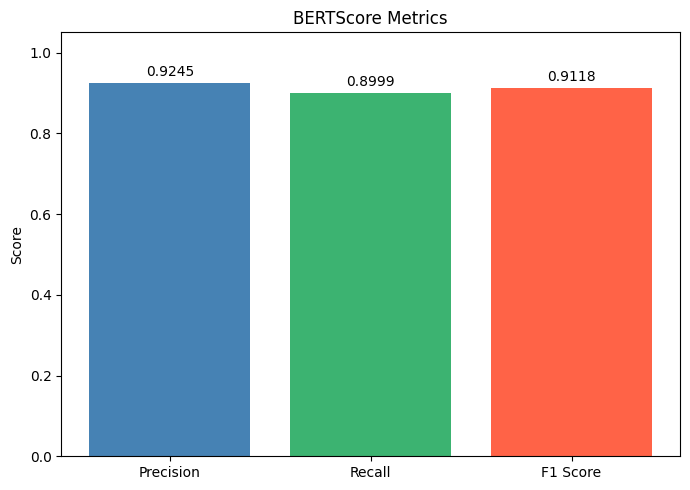

In [ ]:
import matplotlib.pyplot as plt

# Calculate average scores
avg_precision = sum(bert_score['precision']) / len(bert_score['precision'])
avg_recall = sum(bert_score['recall']) / len(bert_score['recall'])
avg_f1 = sum(bert_score['f1']) / len(bert_score['f1'])

# Data for plotting
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [avg_precision, avg_recall, avg_f1]

# Plotting
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics, scores, color=['steelblue', 'mediumseagreen', 'tomato'])

# Annotate scores on bars
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{score:.4f}', ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('BERTScore Metrics')
plt.tight_layout()
plt.show()


In [ ]:
import evaluate

meteor = evaluate.load("meteor")
meteor_score = meteor.compute(predictions=predictions, references=references)
print(f"METEOR Score: {meteor_score['meteor']:.4f}")

# Shows that model captures semantic meaning, correct terminology, and word structure well. Considers exact words and structure.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


METEOR Score: 0.7081


In [ ]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 4.3 MB/s eta 0:00:00


In [ ]:
from pycocoevalcap.cider.cider import Cider
import numpy as np

# CIDEr metric expects inputs in a specific dictionary format
# Convert predictions and references to the required format
cider_predictions = {i: [pred] for i, pred in enumerate(predictions)}
cider_references = {i: [ref] for i, ref in enumerate(references)}

# Compute CIDEr score
cider_scorer = Cider()
(score, scores) = cider_scorer.compute_score(cider_references, cider_predictions)

print(f" CIDEr Score: {score:.4f}")

# Shows that generated reports align well with reference reports and are not overly generic.

 CIDEr Score: 0.8447


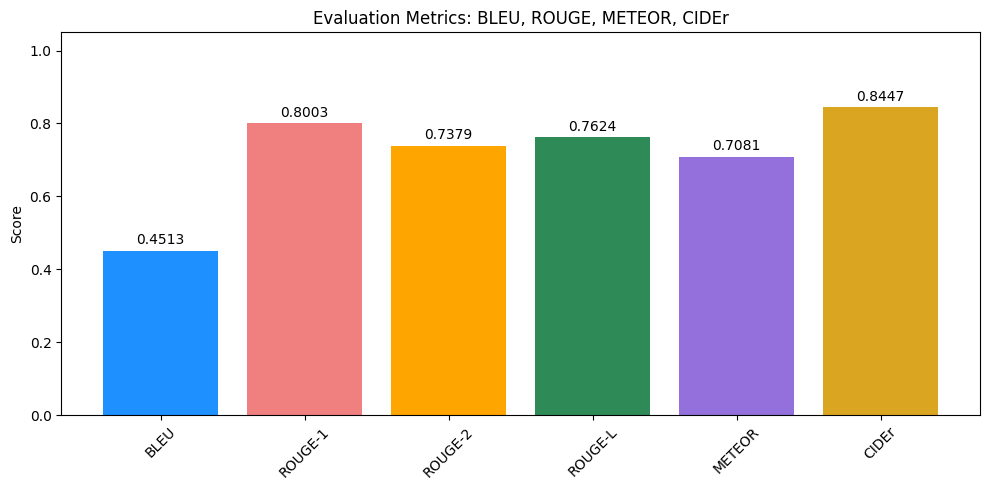

In [ ]:
import matplotlib.pyplot as plt

# === Prepare Scores ===
bleu_val = bleu_score['bleu']
rouge_vals = {
    "ROUGE-1": rouge_score["rouge1"],
    "ROUGE-2": rouge_score["rouge2"],
    "ROUGE-L": rouge_score["rougeL"]
}
meteor_val = meteor_score['meteor']
cider_val = score  # From CIDEr

# === Combine all scores ===
all_scores = {
    "BLEU": bleu_val,
    **rouge_vals,
    "METEOR": meteor_val,
    "CIDEr": cider_val
}

# === Plotting ===
plt.figure(figsize=(10, 5))
bars = plt.bar(all_scores.keys(), all_scores.values(), color=["dodgerblue", "lightcoral", "orange", "seagreen", "mediumpurple", "goldenrod"])

# Add text annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.4f}", ha="center", va="bottom")

plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Evaluation Metrics: BLEU, ROUGE, METEOR, CIDEr")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print("Model config max_length:", model.config.max_length)


Model config max_length: 20


In [ ]:
print("Generated token count:", len(generated_ids[0]))


Generated token count: 236


In [ ]:
from tqdm import tqdm
from PIL import Image

model.eval()

# Number of samples to print
num_samples_to_show = 10

print("\n Generated vs Original Reports:\n")

for i, (imgs, reports, paths) in enumerate(tqdm(test_loader)):
    if i >= num_samples_to_show:
        break

    # Get the image tensor (batch size = 1)
    img_tensor = imgs[0]

    # Convert image to [H, W, C] NumPy array and PIL Image
    if img_tensor.ndim == 3 and img_tensor.shape[0] in [1, 3]:
        img_np = (img_tensor.permute(1, 2, 0).cpu().clamp(0, 1).numpy() * 255).astype("uint8")
    elif img_tensor.ndim == 3 and img_tensor.shape[2] in [1, 3]:
        img_np = (img_tensor.cpu().clamp(0, 1).numpy() * 255).astype("uint8")
    else:
        raise ValueError(f"Unexpected image tensor shape: {img_tensor.shape}")

    pil_img = Image.fromarray(img_np)

    # Tokenize and generate
    inputs = processor(images=pil_img, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values=inputs.pixel_values, max_new_tokens=512,early_stopping=True)

    # Decode predictions and reference
    pred_text = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    ref_text = reports[0]
    img_path = paths[0]  # Assuming paths is a list of strings

    print(f" Sample {i+1}")
    print(f" Image Path: {img_path}")
    print(" Generated Report:")
    print(pred_text)
    print("\n Original Report:")
    print(ref_text)
    print("-" * 100)



 Generated vs Original Reports:



  0%|          | 1/211 [00:05<17:57,  5.13s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 1
 Image Path: /content/data/Infarcts/Infarcts/Acute/Patient 134/Patient 134/RUTIKARAYO_AUGU.CT.Brain_[factory].3.13.2024.02.01.12.58.35.243.48255628.dcm
 Generated Report:
findings : ; there is right occipital and left thalamic regions of hypoattenuation, with loss of gray - white matter noted in the former. the rest of the cerebral parenchyma is normal with normal grey - white matter differentiation. the caudate and lentiform nuclei and the right thalamus are normal. the corpus callosum, the anterior and posterior commissure are normal. the midbrain, pons and medulla are normal. the superior, middle and inferior cerebellar peduncles are normal. the cerebellar vermis and the cerebellar hemispheric parenchyma reveal no abnormality. ventricles and cisterns appear normal. the internal auditory canals and their contents are normal. pituitary gland and sella turcica are normal. no intra sellar or extra sellar lesions. there is left maxillary and left anterior ethmoidal mucosal hype

  1%|          | 2/211 [00:09<16:09,  4.64s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 2
 Image Path: /content/data/Normal Patients/Patient 219_58/Patient 219_58 C&NC/BAGAMBE_MEDIUS.CT.Brain_[factory].5.40.2024.03.31.12.13.02.176.52854896.dcm
 Generated Report:
findings : ; the cerebral hemispheric parenchyma is normal with normal grey - white matter differentiation. the caudate and lentiform nuclei and the thalami are normal. the corpus callosum, the anterior and posterior commissure are normal. the midbrain, pons and medulla are normal. the superior, middle and inferior cerebellar peduncles are normal. the cerebellar vermis and the cerebellar hemispheric parenchyma reveal no abnormality. ventricles and cisterns appear normal. the internal auditory canals and their contents are normal. pituitary gland and sella turcica are normal. no intra sellar or extra sellar lesions. the paranasal sinuses and mastoid air cells are normal. the calvarium is normal. conclusion : the brain ct is within normal limits. no intracranial haemorrhage.

 Original Report:
Findings:
;
Th

  1%|▏         | 3/211 [00:12<13:22,  3.86s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 3
 Image Path: /content/data/Normal Patients/Patient 192_38/Patient 192_38 NC/MWEBAZE__ALEX.CT.Brain_[factory].3.62.2024.03.15.17.39.11.650.57555639.dcm
 Generated Report:
findings : there is no intra - axial lesion in the cerebral hemispheres. the gray - white differentiation is normal. the gyral convolutions are normally distributed. no extra - axial collections demonstrated. the brain stem and the cerebellar hemispheres are normal. the ventricles and basal cisterns are normal. the sella and parasellar structures are normal. both orbits and contents are unremarkable. there is mild peripheral mucosal thickening in the bilateral maxillary sinuses in keeping with acute sinusitis. the rest of the paranasal sinuses are normal. the temporal bones and the mastoid air cells are normal. the cranio - cervical junction and the demonstrated cervical vertebrae are normal. the skull and surrounding soft tissues are normal. conclusion : normal brain ct findings :

 Original Report:
Findings

  2%|▏         | 4/211 [00:16<14:01,  4.06s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 4
 Image Path: /content/data/Infarcts/Infarcts/Acute/Patient 166_49 NC/BUJJINGO BOSCO/8.dcm
 Generated Report:
findings : the left middle cerebral artery is hyperdense compared to the right giving a dense mca sign. there are bihemispheric, non - enhancing, asymmetrical, cerebralpredominantly left anterior horn periventricular and centrum semiovale hypoattenuating to normal brain lesions ( 20 - 23hu ) with no demonstrable mass effect. a subtle ill - defined hypodense lesion is noted in the left parietal lobe. mucosal thickening is noted in the bilateral maxillary sinuses, the rest of the paranasal sinuses and the mastoid air cells appear normal. the rest of the brain parenchyma exhibits normalattenuationpattern. the middle and inner ear contents are unremarkable. the mastoid air cells appear normal. the skull and facial bones appear normal. the demonstrated cervical spine appears intact. conclusion : features are consistent with : 1. a hyperdense left middle cerebral artery whic

  2%|▏         | 5/211 [00:20<13:21,  3.89s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 5
 Image Path: /content/data/Normal Patients/Patient 161_53/Patient 161_53 NC/KYOMUHENDO_MABL.CT.Brain_[factory].3.4.2024.06.06.11.08.58.257.11453794.dcm
 Generated Report:
findings : the brain parenchyma ; cerebrum, cerebellar and brain stem, appears normal exhibiting normal attenuation with no demonstrable mass lesion or mass effect. the sulceal foci and gyri appear normal for patient age. the triventricular components are exhibiting normal caliber and unremarkable intrinsic contents. the bilateral internal auditory meatus are exhibiting normal caliber and attenuation. the middle and inner ear contents are unremarkable. the bilateral orbital contents and optic tract region, are unremarkable. the demonstrated para nasal air sinuses appear well pneumatized. the skull bones appear normal. there is normal congruity along the cranio - cervical junction with intact components. conclusion : this is an unremarkable ct scan examination with no evidence of neither extra nor intra axial

  3%|▎         | 6/211 [00:25<14:16,  4.18s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 6
 Image Path: /content/data/Normal Patients/Patient 134_58/Patient 134_58 C&NC/GUMISIRIZA_STEV.CT.Brain_[factory].4.27.2024.01.23.11.55.24.557.75151850.dcm
 Generated Report:
findings : the brain parenchyma ; cerebrum, cerebellar and brain stem, appears normal exhibiting normal attenuation and unremarkable enhancement pattern with no demonstrable mass lesion or mass effect. the bihemispheric cerebral sulceal foci appear normal for patient age. the triventricular components are exhibiting normal caliber and unremarkable intrinsic contents. the bilateral internal auditory meatus are exhibiting normal caliber and attenuation. the cerebellar angles are almost comparable and unremarkable. the middle and inner ear contents are unremarkable. the demonstrated bilateral orbital contents and optical tract regions are unremarkable. there is concentric mucosal thickening evident along the bilateral maxillary antral walls. the rest of the demonstrated para nasal air sinuses are optimally p

  3%|▎         | 7/211 [00:29<14:53,  4.38s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 7
 Image Path: /content/data/Infarcts/Infarcts/Acute/Patient 96/Patient 96/KYOBUBIRE_MODES.CT.Brain_[factory].3.15.2024.01.05.12.31.29.948.66072326.dcm
 Generated Report:
findings : ; there is a large region of right frontoparietal hypoattenuation with loss of gray - white matter differentiation. the rest of the cerebral parenchyma is normal with normal grey - white matter differentiation. the caudate and lentiform nuclei and the thalami are normal. the corpus callosum, the anterior and posterior commissure are normal. the midbrain, pons and medulla are normal. the superior, middle and inferior cerebellar peduncles are normal. the cerebellar vermis and the cerebellar hemispheric parenchyma reveal no abnormality. ventricles and cisterns appear normal. the internal auditory canals and their contents are normal. pituitary gland and sella turcica are normal. no intra sellar or extra sellar lesions. the paranasal sinuses and mastoid air cells are normal. the calvarium is normal. con

  4%|▍         | 8/211 [00:35<16:16,  4.81s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 8
 Image Path: /content/data/Normal Patients/Patient 153_34/Patient 153_34 C&NC/KENGABIRANO_DON.CT.Brain_[factory].4.4.2024.03.09.17.13.54.946.23084333.dcm
 Generated Report:
findings : patient : kengabirano, donamu date of birth : 05 / 03 / 1990 date of study : 05 / 03 / 2024 02 : 27 pm patient location : out patient patient id : 2024. 03. 05 - 13 : 21 : 33 - std - 1. 3. 12. 2. 1107. 5. 99. 3 ref physician : acc number : electronically signed by : dr. apolot denise consultant radiologist afyarad mayanja memorial hospital ltd p. o box 920 plot 175 masaka rd nyamityobora mayanjamemorial @ gmail. com mbarara uganda radiology report created 05 / 03 / 2024 02 : 48 pm ct, head / brain w, w / o contrast clinical summary : persistent headache serial axial pre and post contrast scans were obtained from the base of skull to the vertex. there was no intracranial space occupying mass or hematoma. the ventricular system was normal and there was no mid line shift. no abnormal cerebral or ce

  4%|▍         | 9/211 [00:39<15:02,  4.47s/it]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 Sample 9
 Image Path: /content/data/Normal Patients/Patient 29_17/MUGABO YOWERI/143.dcm
 Generated Report:
findings : ; the cerebral hemispheric parenchyma is normal with normal grey - white matter differentiation. no focal enhancing lesions noted. the caudate and lentiform nuclei and the thalami are normal. the corpus callosum, the anterior and posterior commissure are normal. the midbrain, pons and medulla are normal. the superior, middle and inferior cerebellar peduncles are normal. the cerebellar vermis and the cerebellar hemispheric parenchyma reveal no abnormality. ventricles and cisterns appear normal. the major cerebral arteries and venous sinuses are normal. the internal auditory canals and their contents are normal. pituitary gland and sella turcica are normal. no intra sellar or extra sellar lesions. the paranasal sinuses and mastoid air cells are normal. the calvarium is normal. the orbits and internal contents are normal. conclusion : the above features are of a normal br

  5%|▍         | 10/211 [00:41<14:00,  4.18s/it]

 Sample 10
 Image Path: /content/data/Normal Patients/Patient 86_62/Patient 86_62 NC/SIDIYA_KAJWENGY.CT.Brain_[factory].3.8.2024.01.23.11.55.24.557.75163708.dcm
 Generated Report:
findings : there is no intra - axial lesion in the cerebral hemispheres. the gray - white differentiation is normal. the gyral convolutions are normally distributed. no extra - axial collections demonstrated. the brain stem and the cerebellar hemispheres are normal. the ventricles and basal cisterns are normal. the sella and parasellar structures are normal. both orbits and contents are unremarkable. the paranasal sinuses are normal. the temporal bones and the mastoid air cells are normal. the cranio - cervical junction and the demonstrated cervical vertebrae are normal. the skull and surrounding soft tissues are normal. conclusion : normal head ct findings :

 Original Report:
Findings:
There is no intra-axial lesion in the cerebral hemispheres. The gray-white differentiation is normal. The gyral
convolution